This first part is only needed as we have to mock VASP here as we cannot run it directly in a jupyter notebook:

In [1]:
from mock_vasp import TEST_DIR, mock_vasp

ref_paths = {
    "tight relax 1": "Si_gruneisen_tutorial/tight_relax_1_0",
    "tight relax 2": "Si_gruneisen_tutorial/tight_relax_2_1",
    "tight relax 1 plus": "Si_gruneisen_tutorial/tight_relax_1_plus_3",
    "tight relax 2 plus": "Si_gruneisen_tutorial/tight_relax_2_plus_5",
    "tight relax 1 minus": "Si_gruneisen_tutorial/tight_relax_1_minus_4",
    "tight relax 2 minus": "Si_gruneisen_tutorial/tight_relax_2_minus_6",
    "dft phonon static 1/1 ground": "Si_gruneisen_tutorial/dft_phonon_static_1_1_ground_24",
    "dft phonon static 1/1 plus": "Si_gruneisen_tutorial/dft_phonon_static_1_1_plus_26",
    "dft phonon static 1/1 minus": "Si_gruneisen_tutorial/dft_phonon_static_1_1_minus_28",
}

/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from atomate2.vasp.flows.core import DoubleRelaxMaker
from atomate2.vasp.jobs.core import TightRelaxMaker
from atomate2.vasp.jobs.phonons import PhononDisplacementMaker
from atomate2.vasp.sets.core import StaticSetGenerator, TightRelaxSetGenerator

# Grüneisen Workflow Tutorial with VASP

## Background
The Grüneisen workflow is based on the implementation in Phonopy.

If you want to read more about Phonopy, please read Togo’s paper: https://doi.org/10.7566/JPSJ.92.012001

## Let's run the workflow
Now, we load a structure and other important functions and classes for running the Grüneisen workflow.

In [3]:
from jobflow import JobStore, run_locally
from maggma.stores import MemoryStore
from pymatgen.core import Structure

from atomate2.vasp.flows.gruneisen import GruneisenMaker, PhononMaker

job_store = JobStore(MemoryStore(), additional_stores={"data": MemoryStore()})
si_structure = Structure.from_file(TEST_DIR / "structures" / "Si_diamond.cif")

In [4]:
phonon_displacement_maker = PhononDisplacementMaker(
    name="dft phonon static",
    run_vasp_kwargs={"handlers": ()},
    input_set_generator=StaticSetGenerator(
        user_incar_settings={
            "GGA": "PE",
            "IBRION": -1,
            "ISPIN": 1,
            "ISMEAR": 0,
            "ISIF": 3,
            "ENCUT": 700,
            "EDIFF": 1e-7,
            "LAECHG": False,
            "LREAL": False,
            "ALGO": "Normal",
            "NSW": 0,
            "LCHARG": False,
            "LWAVE": False,
            "LVTOT": False,
            "LORBIT": None,
            "LOPTICS": False,
            "SIGMA": 0.05,
            "ISYM": 0,
            "KSPACING": 0.1,
            "NPAR": 4,
        },
        auto_ispin=False,
    ),
)

In [5]:
phonon_bulk_relax_maker_isif3 = DoubleRelaxMaker.from_relax_maker(
    TightRelaxMaker(
        run_vasp_kwargs={"handlers": ()},
        input_set_generator=TightRelaxSetGenerator(
            user_incar_settings={
                "GGA": "PE",
                "ISPIN": 1,
                "KSPACING": 0.1,
                # "EDIFFG": 1e-5,
                "ALGO": "Normal",
                "LAECHG": False,
                "ISMEAR": 0,
                "ENCUT": 700,
                "IBRION": 1,
                "ISYM": 0,
                "SIGMA": 0.05,
                "LCHARG": False,
                "LWAVE": False,
                "LVTOT": False,
                "LORBIT": None,
                "LOPTICS": False,
                "LREAL": False,
                "ISIF": 3,
                "NPAR": 4,
            }
        ),
    )
)

Then one can use the `GruneisenMaker` to generate a `Flow`.

In [6]:
flow = GruneisenMaker(
    symprec=1e-4,
    bulk_relax_maker=phonon_bulk_relax_maker_isif3,
    phonon_maker=PhononMaker(
        generate_frequencies_eigenvectors_kwargs={"tmin": 0, "tmax": 1000, "tstep": 10},
        min_length=10,
        bulk_relax_maker=None,
        born_maker=None,
        static_energy_maker=None,
        phonon_displacement_maker=phonon_displacement_maker,
    ),
).make(structure=si_structure)

<string>:14: UserWarning: You are using different symmetry precisions in the phonon makers and other parts of the Grüneisen workflow.


The Grüneisen parameter workflow will perform 3 different phonon runs at 3 different volumes at and around the equilibrium to compute the mode Grüneisen values.

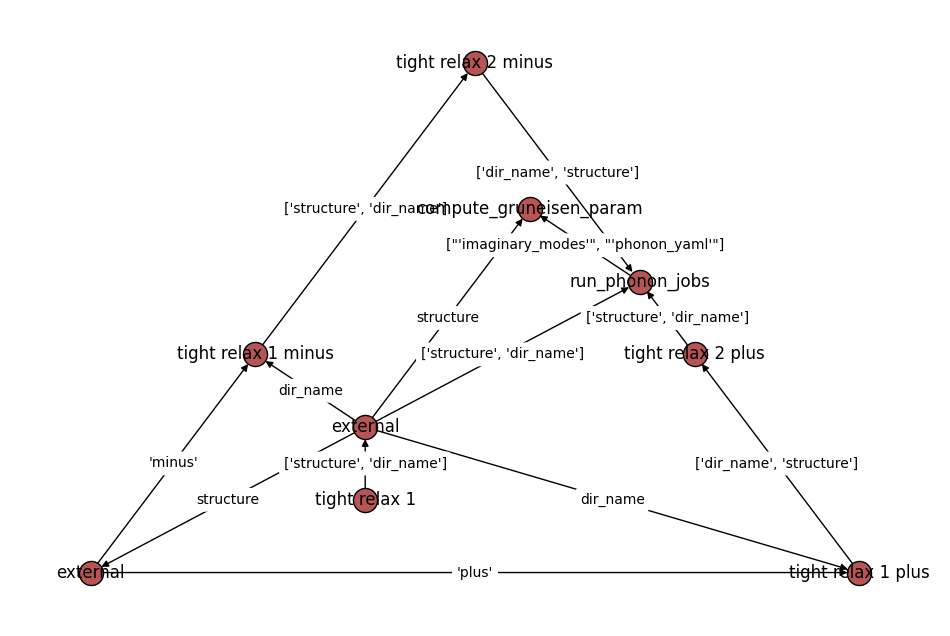

In [7]:
flow.draw_graph().show()

We now run the flow with  `run_locally`. We mock the run here. Normally, you would simply use `run_locally` without the `with mock_vasp`

In [8]:
with mock_vasp(ref_paths=ref_paths) as mf:
    run_locally(
        flow,
        create_folders=True,
        ensure_success=True,
        raise_immediately=True,
        store=job_store,
    )

2025-02-18 12:49:16,935 INFO Started executing jobs locally
2025-02-18 12:49:16,942 INFO Starting job - tight relax 1 (163c7f5e-2e7b-408f-981a-3ae5e8ee0788)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1219: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-18 12:49:18,218 INFO Finished job - tight relax 1 (163c7f5e-2e7b-408f-981a-3ae5e8ee0788)
2025-02-18 12:49:18,218 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:18,219 INFO Starting job - tight relax 2 (116b544c-433f-44a8-a1aa-2c2f4abcb501)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-18-219213-32554/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-18 12:49:19,680 INFO Finished job - tight relax 2 (116b544c-433f-44a8-a1aa-2c2f4abcb501)
2025-02-18 12:49:19,680 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:19,681 INFO Starting job - shrink_expand_structure (0f23a0c8-6e21-465a-b323-bf090628704c)
2025-02-18 12:49:19,699 INFO Finished job - shrink_expand_structure (0f23a0c8-6e21-465a-b323-bf090628704c)
2025-02-18 12:49:19,700 INFO Starting job - tight relax 1 plus (f2eb1309-2b44-4184-81c5-b8762cb28244)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-19-699641-80429/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:49:20,298 INFO Finished job - tight relax 1 plus (f2eb1309-2b44-4184-81c5-b8762cb28244)
2025-02-18 12:49:20,299 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:20,300 INFO Starting job - tight relax 1 minus (0d9060fa-559b-410c-937d-d48c82ee1ddc)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-20-299876-15172/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:49:21,027 INFO Finished job - tight relax 1 minus (0d9060fa-559b-410c-937d-d48c82ee1ddc)
2025-02-18 12:49:21,027 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:21,028 INFO Starting job - tight relax 2 plus (46166685-88a0-4c8d-b1f8-74327c0ad8c0)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-21-028003-52432/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:49:21,360 INFO Finished job - tight relax 2 plus (46166685-88a0-4c8d-b1f8-74327c0ad8c0)
2025-02-18 12:49:21,360 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:21,361 INFO Starting job - tight relax 2 minus (91a1ac6c-d6fd-4927-8c34-d57fc6a602f6)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-21-361042-50432/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:49:21,831 INFO Finished job - tight relax 2 minus (91a1ac6c-d6fd-4927-8c34-d57fc6a602f6)
2025-02-18 12:49:21,832 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:21,832 INFO Starting job - run_phonon_jobs (41ec4d30-07ec-49bc-86b2-5c36543a46aa)
2025-02-18 12:49:21,981 INFO Finished job - run_phonon_jobs (41ec4d30-07ec-49bc-86b2-5c36543a46aa)
2025-02-18 12:49:21,997 INFO Starting job - get_supercell_size ground (4cce137b-af2a-495b-a618-2c124d4f2212)
2025-02-18 12:49:22,000 INFO Finished job - get_supercell_size ground (4cce137b-af2a-495b-a618-2c124d4f2212)
2025-02-18 12:49:22,001 INFO Starting job - generate_phonon_displacements ground (b073caad-c765-48e9-b827-8938799d2528)
2025-02-18 12:49:22,182 INFO Finished job - generate_phonon_displacements ground (b073caad-c765-48e9-b827-8938799d2528)
2025-02-18 12:49:22,182 INFO Starting job - run_phonon_displacements ground (ac973f54-b6da-4d58-a900-cdd75af9e098)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/flow.py:431: UserWarning: Some jobs are not connected, their ordering may be random
  for node in itergraph(graph):
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/job.py:604: UserWarning: Initial magnetic moments will not be considered for the determination of the symmetry of the structure and thus will be removed now.
  response = function(*self.function_args, **self.function_kwargs)


2025-02-18 12:49:22,294 INFO Finished job - run_phonon_displacements ground (ac973f54-b6da-4d58-a900-cdd75af9e098)
2025-02-18 12:49:22,302 INFO Starting job - dft phonon static 1/1 ground (bea34318-d7c2-4d36-b16e-4a65ce4cee61)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-22-302221-65634/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:49:23,312 INFO Finished job - dft phonon static 1/1 ground (bea34318-d7c2-4d36-b16e-4a65ce4cee61)
2025-02-18 12:49:23,313 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:23,314 INFO Starting job - store_inputs ground (ac973f54-b6da-4d58-a900-cdd75af9e098, 2)
2025-02-18 12:49:23,315 INFO Finished job - store_inputs ground (ac973f54-b6da-4d58-a900-cdd75af9e098, 2)
2025-02-18 12:49:23,315 INFO Starting job - generate_frequencies_eigenvectors ground (3f8522a2-376c-43c2-a13f-c338ba5a0cfc)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-18 12:49:30,545 INFO Finished job - generate_frequencies_eigenvectors ground (3f8522a2-376c-43c2-a13f-c338ba5a0cfc)
2025-02-18 12:49:30,546 INFO Starting job - get_supercell_size plus (1a12245f-3b18-4350-a369-8a7964f8855a)
2025-02-18 12:49:30,550 INFO Finished job - get_supercell_size plus (1a12245f-3b18-4350-a369-8a7964f8855a)
2025-02-18 12:49:30,551 INFO Starting job - generate_phonon_displacements plus (595ea64f-47e0-4c16-8208-6abbb988601a)
2025-02-18 12:49:30,732 INFO Finished job - generate_phonon_displacements plus (595ea64f-47e0-4c16-8208-6abbb988601a)
2025-02-18 12:49:30,733 INFO Starting job - run_phonon_displacements plus (8d26e5e2-232f-45c8-b4cd-e526fe9e4117)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/job.py:604: UserWarning: Initial magnetic moments will not be considered for the determination of the symmetry of the structure and thus will be removed now.
  response = function(*self.function_args, **self.function_kwargs)


2025-02-18 12:49:30,844 INFO Finished job - run_phonon_displacements plus (8d26e5e2-232f-45c8-b4cd-e526fe9e4117)
2025-02-18 12:49:30,852 INFO Starting job - dft phonon static 1/1 plus (c339397d-b940-4903-ab1d-bdd39daa2175)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-30-852651-16326/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1219: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))


2025-02-18 12:49:31,463 INFO Finished job - dft phonon static 1/1 plus (c339397d-b940-4903-ab1d-bdd39daa2175)
2025-02-18 12:49:31,464 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:31,465 INFO Starting job - store_inputs plus (8d26e5e2-232f-45c8-b4cd-e526fe9e4117, 2)
2025-02-18 12:49:31,466 INFO Finished job - store_inputs plus (8d26e5e2-232f-45c8-b4cd-e526fe9e4117, 2)
2025-02-18 12:49:31,467 INFO Starting job - generate_frequencies_eigenvectors plus (a8e46d00-a8f0-40f2-a2fb-53a9af61f54c)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-18 12:49:38,987 INFO Finished job - generate_frequencies_eigenvectors plus (a8e46d00-a8f0-40f2-a2fb-53a9af61f54c)
2025-02-18 12:49:38,989 INFO Starting job - get_supercell_size minus (26defd29-38f6-41b6-8dc9-ad6849934dd4)
2025-02-18 12:49:38,992 INFO Finished job - get_supercell_size minus (26defd29-38f6-41b6-8dc9-ad6849934dd4)
2025-02-18 12:49:38,993 INFO Starting job - generate_phonon_displacements minus (8fd3866c-f8c1-4b21-8989-f0de80fdfc93)
2025-02-18 12:49:39,174 INFO Finished job - generate_phonon_displacements minus (8fd3866c-f8c1-4b21-8989-f0de80fdfc93)
2025-02-18 12:49:39,175 INFO Starting job - run_phonon_displacements minus (dcd6e4e5-8a6d-4e78-a2b0-566b84f60a5a)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/job.py:604: UserWarning: Initial magnetic moments will not be considered for the determination of the symmetry of the structure and thus will be removed now.
  response = function(*self.function_args, **self.function_kwargs)


2025-02-18 12:49:39,287 INFO Finished job - run_phonon_displacements minus (dcd6e4e5-8a6d-4e78-a2b0-566b84f60a5a)
2025-02-18 12:49:39,296 INFO Starting job - dft phonon static 1/1 minus (9edc101a-f678-4f8d-9a58-8c0bc4b4da34)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4wq6km22/job_2025-02-18-11-49-39-296498-13043/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1219: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))


2025-02-18 12:49:39,913 INFO Finished job - dft phonon static 1/1 minus (9edc101a-f678-4f8d-9a58-8c0bc4b4da34)
2025-02-18 12:49:39,913 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:49:39,914 INFO Starting job - store_inputs minus (dcd6e4e5-8a6d-4e78-a2b0-566b84f60a5a, 2)
2025-02-18 12:49:39,916 INFO Finished job - store_inputs minus (dcd6e4e5-8a6d-4e78-a2b0-566b84f60a5a, 2)
2025-02-18 12:49:39,917 INFO Starting job - generate_frequencies_eigenvectors minus (51649220-c47f-4f64-89a5-b3552993bb89)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-18 12:49:47,259 INFO Finished job - generate_frequencies_eigenvectors minus (51649220-c47f-4f64-89a5-b3552993bb89)
2025-02-18 12:49:47,260 INFO Starting job - compute_gruneisen_param (b7843b03-e63c-41dc-a1de-8f73a0b4c69b)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-18 12:50:07,533 INFO Finished job - compute_gruneisen_param (b7843b03-e63c-41dc-a1de-8f73a0b4c69b)
2025-02-18 12:50:07,534 INFO Finished executing jobs locally


In [9]:
job_store.connect()

result = job_store.query_one(
    {"name": "compute_gruneisen_param"},
    properties=[
        "output.gruneisen_band_structure",
        "output.gruneisen_parameter",
    ],
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='Frequencies (THz)'>

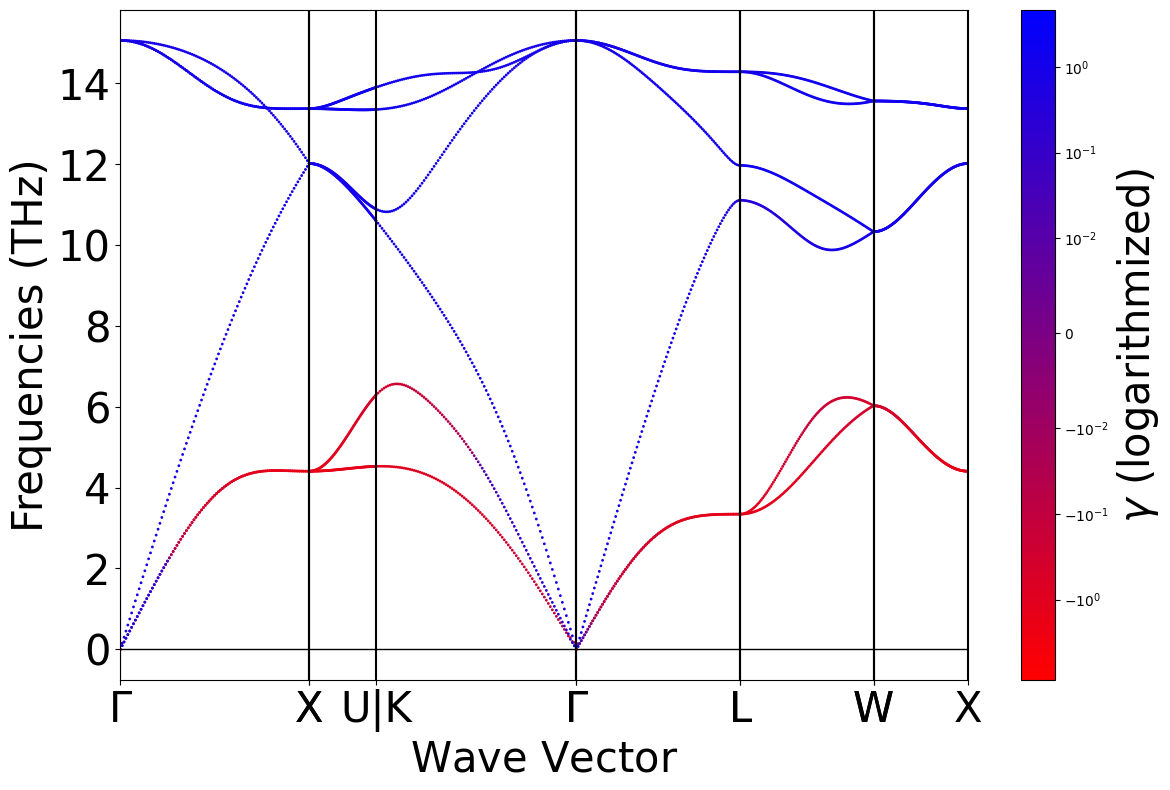

In [10]:
from pymatgen.phonon.gruneisen import GruneisenPhononBandStructureSymmLine
from pymatgen.phonon.plotter import GruneisenPhononBSPlotter

bs = GruneisenPhononBandStructureSymmLine.from_dict(
    result["output"]["gruneisen_band_structure"]
)
plt = GruneisenPhononBSPlotter(bs=bs)
plt.get_plot_gs(plot_ph_bs_with_gruneisen=True)